# TensorFlow Implementaton of Laplace Approximation for GP Hyperparameters (w/ Internal Newton Optimiser)
This is an example python script to illustrate LA GP fitting with TensorFlow

## Step 1: Read in summarised TRaC data with matched covariates and build as TensorFlow constants 

- Age restricted to 1-50 y/o (to limit impact of maternal anti-bodies and limit look-back time)

- Sites snapped to land-sea mask boundary and standardised covariates extracted

- Area including Port-au-Prince and surrounds excluded (to limit impact of migration) 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.io import mmread
import osgeo.gdal as gdal
import os
import matplotlib.pyplot as plt
import ndes.ndes as ndes
import pickle
import distributions.priors as priors

# Start a tensorflow session
sess = tf.Session(config = tf.ConfigProto())
sess.run(tf.global_variables_initializer())

# Number of antibodies and serology parameters
n_antibodies = 1
n_parameters = 16

# Import the trac data
tracdata = pd.read_csv('../trac_data/summary_TRaC_data_with_covariates.csv')

# Village positions
village_lats = tracdata.groupby(['Cluster_Num'])['Latitude'].unique().values
village_longs = tracdata.groupby(['Cluster_Num'])['Longitude'].unique().values

# Number of villages
Nvillages = tracdata.Cluster_Num.unique().size

# Extract the AMA titres and ages for all individuals, grouped by village
titres = np.log(1e-27+tracdata.AMA.values[tracdata.AMA.values>0])
ages = tracdata.Age.values[tracdata.AMA.values>0]
cluster_assignments = tracdata.Cluster_Num.values[tracdata.AMA.values>0]

# Number of individuals
Nindividuals = len(tracdata.Age.values[tracdata.AMA.values>0])

# Extract the mean covariates in each cell
covariates = tracdata.groupby(['Cluster_Num'])['covariate_accessibility','covariate_AI','covariate_distTowater','covariate_elevation','covariate_forest','covariate_grass','covariate_urbanbarren','covariate_woodysavanna','covariate_OSM','covariate_PET','covariate_slope','covariate_TWI'].mean().values

# Number of covariates
Ncovariates = covariates.shape[1]

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# Load in the batch normalizations for re-scaling inputs to the neural likelihood
f = open('data/batch_normalizations.pkl', 'rb')
xs_mean, xs_std, ps_mean, ps_std = pickle.load(f)
f.close()

# Data = individual titres re-scaled by batch norms for input to the neural likelihood
data_individual = (np.expand_dims(titres,1)-xs_mean)/ xs_std

In [3]:
# Read in matrices for INLA mesh projections

# Projection from INLA grid to cluster locations
Amatrix = mmread('data/A_matrix.mtx')

# Size of INLA grid
Nmesh = Amatrix.shape[1]

# The various bits of the SPDE precision matrix (on the INLA grid)
M0 = mmread('data/M0_matrix.mtx')
M1 = mmread('data/M1_matrix.mtx')
M2 = mmread('data/M2_matrix.mtx')

# Cast to tf constants
Amatrix = Amatrix.toarray() # Not sure if it's worth figuring out how to use SparseTensors
M0 = M0.toarray()
M1 = M1.toarray()
M2 = M2.toarray()

# Matrix to project INLA triangular grid to the full resolution of the covariates
Afullmatrix = mmread('data/Afull_matrix.mtx')
Afullmatrix = Afullmatrix.toarray()

In [4]:
# GP hyper-parameter kappa
log_kappa = 1.0
#prior_log_kappa = tfp.distributions.Normal(loc = 0.0, scale = 1.0)

log_tau = -3.0
#prior_log_tau = tfp.distributions.Normal(loc = 0.0, scale = 1.0)

# Set-up GP for the log-field
log_field = np.zeros(Nmesh)
spde_prec = (np.exp(log_kappa*4.0)*M0 + 2*np.exp(log_kappa*2.0)*M1 + M2)*np.exp(log_tau*2)
spde_cov = np.linalg.inv(spde_prec)
#prior_log_field = tfp.distributions.MultivariateNormalFullCovariance(loc = tf.constant(np.zeros(Nmesh), dtype='float32'), covariance_matrix = spde_cov)

# Slopes and intercept for linear predictor part of the model
slopes = np.zeros(Ncovariates)
#prior_slopes = tfp.distributions.Normal(loc = 0.0, scale = 1.0)
intercept = 0.0
#prior_intercept = tfp.distributions.Normal(loc = 0.0, scale = 5.0)

# Serology hyper-parameters

serology = np.array([0.2, # f_biting
                    12, # a0_biting
                    0.5, # beta_biting
                    10, # tau0
                    0.1, # f_tau
                    10, # a0_tau
                    2, # beta_tau
                    np.log(10)/3, # sigma_H
                    0.026*np.log(10), # eta
                    -2*np.log(10), # logxmin
                    0.018*np.log(10), # s
                    0.242*np.log(10), # q
                    0.09/np.log(10), # z
                    17, # mu0
                    4 # s0
                    ])

serology_lower = np.array([ 0,  10,  0.3,
        8,  0,  8,  1,
        0.383764182,  0.0230258509, -6.90775528,  0.0230258509,
        0.230258509,  0.00434294482,  15,  3])

serology_upper = np.array([ 0.5, 14.        ,  0.7       , 12.        ,
        0.3       , 12.        ,  3.        ,  3.45387764,  0.11512925,
       -2.30258509,  0.11512925,  0.92103404,  0.0868589 , 20.        ,
        5.        ])

prior_serology = priors.Uniform(serology_lower, serology_upper)

# Prior over the EIR
prior_EIR = priors.Uniform(0, 5)

In [5]:
# Linear predictor model for EIR: GP + C\beta + \beta_0
#linear_predictor = np.squeeze(np.matmul(Amatrix,np.expand_dims(log_field,1))) + intercept + np.squeeze(np.matmul(covariates,np.expand_dims(slopes,1)))

# Set up the parameters vector
#theta = np.array([np.concatenate([np.array([np.exp(linear_predictor[cluster_assignments[i]-1])]), serology, np.array([ages[i]])]) for i in range(Nindividuals)])
#theta = (theta - ps_mean)/ ps_std
#theta = (tf.concat([tf.expand_dims(tf.gather(tf.exp(linear_predictor), cluster_assignments-1),1), 
#                                    tf.transpose(tf.tile(tf.reshape(serology, [-1,1]), [1,Nindividuals])), 
#                                    tf.expand_dims(ages,1)], axis=1) - ps_mean)/ ps_std

In [6]:
# Load the network weights and pickle them for re-loading later

# Create the NDE object
#NDE = ndes.MixtureDensityNetwork(n_inputs=n_parameters + 1, 
#                                 n_outputs=n_antibodies,
#                                 n_components=6, 
#                                 n_hidden=[100,100], 
#                                 activations=[tf.tanh, tf.tanh])

# Restore the graph from the trained neural density estimator
#saver = tf.train.Saver()
#saver.restore(sess,"./tmp_model")

In [7]:
# Build the neural likelihood

# my (correct) solution:
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div

# Build lower triangular matrices (parameterizing the covariances) from network output (also calculate determinant)
def lower_triangular_matrix(σ):
    Σ = []
    det = []
    start = 0
    end = 1
    for i in range(D):
        exp_val = np.exp(σ[:, :, end-1])
        det.append(exp_val)
        if i > 0:
            Σ.append(np.pad(np.concatenate([σ[:, :, start:end-1], np.expand_dims(exp_val, -1)], -1), [[0, 0], [0, 0], [0, D-i-1]], 'constant'))
        else:
            Σ.append(np.pad(np.expand_dims(exp_val, -1), [[0, 0], [0, 0], [0, D-i-1]], 'constant'))
        start = end
        end += i + 2
    Σ = np.transpose(np.stack(Σ), (1, 2, 0, 3))
    det = np.prod(np.stack(det), 0)
    return Σ, det

# Split network output into component means, covariances and weights (also returns determinant of covariance)
def mapping(output_layer, M, D):
    μ, Σ, α = np.split(output_layer, [M * D, M * D + M * D * (D + 1) // 2], 1)
    μ = np.reshape(μ, (-1, M, D))
    Σ, det = lower_triangular_matrix(np.reshape(Σ, (-1, M, D * (D + 1) // 2)))
    α = softmax(α)#np.exp(α)/np.sum(np.exp(α), axis = 0)
    return μ, Σ, α, det

# Load in the network weights and biases
f = open('data/network_weights.pkl', 'rb')
weights = pickle.load(f)
f.close()

f = open('data/network_biases.pkl', 'rb')
biases = pickle.load(f)
f.close()

# Set-up
D = n_antibodies # size of data (number of antibodies)
P = n_parameters + 1 # number of parameters (num serology parameters + EIR + age)
M = 6 # number of Gaussian components
N = int((D + D * (D + 1) / 2 + 1)*M)
n_hidden = [100,100]

# Define the python callable log likelihood
def log_likeihood(theta):
    
    # Build the layers of the network
    layers = [theta] # First layer is just the parameters

    # Now loop through the hidden layers
    for i in range(len(n_hidden)):
        if i < len(n_hidden) - 1:
            layers.append(np.tanh(np.matmul(layers[i], weights[i]) + biases[i]))
        else:
            layers.append(np.matmul(layers[i], weights[i]) + biases[i])
            
    # Map the output layer to mixture model parameters
    μ, Σ, α, det = mapping(layers[-1], M, D)

    # Log likelihood
    return np.sum(np.log(np.sum(np.exp(-0.5*np.sum((np.einsum("ijlk,ijk->ijl", Σ, np.expand_dims(data_individual, 1) - μ))**2, axis=2) + np.log(α) + np.log(det) - D*np.log(2. * np.pi) / 2.), 1) + 1e-37))

# Log posterior
def log_posterior(x):
    
    # Construct parameters vector
    theta = (np.array([np.concatenate([x, np.atleast_1d(ages[i])]) for i in range(len(ages))]) - ps_mean) / ps_std

    return log_likeihood(theta) + prior_serology.log_pdf(x[1:]) + prior_EIR.log_pdf(x[0])
    

In [8]:
# Import mock data for a single site
f = open('mock_data_single_site/data.pkl', 'rb')
titres = pickle.load(f)
data_individual = (titres - xs_mean)/xs_std
f.close()

f = open('mock_data_single_site/ages.pkl', 'rb')
ages = pickle.load(f)
f.close()

In [9]:
# Now run the HMC sampler

# Set the initial state
initial_state = np.concatenate([np.array([2]), serology])

# Step size variable
step_size = tf.get_variable(
    name='step_size',
    initializer=np.ones(16)*0.05,
    use_resource=True,
    trainable=False)

# Initialize the HMC transition kernel.
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_posterior,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy())

# Run the chain (with burn-in).
samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=int(10e3),
    num_burnin_steps=int(1e3),
    current_state=initial_state,
    kernel=hmc)

# Initialize all constructed variables.
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    init_op.run()
    samples, kernel_results = sess.run([samples, kernel_results])


ValueError: zero-dimensional arrays cannot be concatenated

In [14]:
tf.global_variables_initializer()
sess.run(initial_state)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[{{node _retval_Variable_0_0}} = _Retval[T=DT_DOUBLE, index=0, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable)]]

In [11]:
theta = (np.array([np.concatenate([initial_state, np.atleast_1d(ages[i])]) for i in range(len(ages))]) - ps_mean) / ps_std

ValueError: zero-dimensional arrays cannot be concatenated

In [5]:
# Set up the neural density estimator

# Build lower triangular matrices (parameterizing the covariances) from network output (also calculate determinant)
def lower_triangular_matrix(σ):
    Σ = []
    det = []
    start = 0
    end = 1
    for i in range(D):
        exp_val = tf.exp(σ[:, :, end-1])
        det.append(exp_val)
        if i > 0:
            Σ.append(tf.pad(tf.concat([σ[:, :, start:end-1], tf.expand_dims(exp_val, -1)], -1), [[0, 0], [0, 0], [0, D-i-1]]))
        else:
            Σ.append(tf.pad(tf.expand_dims(exp_val, -1), [[0, 0], [0, 0], [0, D-i-1]]))
        start = end
        end += i + 2
    Σ = tf.transpose(tf.stack(Σ), (1, 2, 0, 3))
    det = tf.reduce_prod(tf.stack(det), 0)
    return Σ, det

# Split network output into component means, covariances and weights (also returns determinant of covariance)
def mapping(output_layer, M, D):
    μ, Σ, α = tf.split(output_layer, [M * D, M * D * (D + 1) // 2, M], 1)
    μ = tf.reshape(μ, (-1, M, D))
    Σ, det = lower_triangular_matrix(tf.reshape(Σ, (-1, M, D * (D + 1) // 2)))
    α = tf.nn.softmax(α)
    return μ, Σ, α, det

# Load in the network weights and biases
f = open('data/network_weights.pkl', 'rb')
wghts = pickle.load(f)
f.close()

f = open('data/network_biases.pkl', 'rb')
bss = pickle.load(f)
f.close()

# Declare weights and biases as constants
weights = [tf.constant(wghts[0], dtype='float32'), tf.constant(wghts[1], dtype='float32')]
biases = [tf.constant(bss[0], dtype='float32'), tf.constant(bss[1], dtype='float32')]

# Set-up
D = n_antibodies # size of data (number of antibodies)
P = n_parameters + 1 # number of parameters (num serology parameters + EIR + age)
M = 6 # number of Gaussian components
N = int((D + D * (D + 1) / 2 + 1)*M)
n_hidden = [100,100]
activations = [tf.tanh, tf.tanh]

# Build the layers of the network
layers = [theta] # First layer is just the parameters

# Now loop through the hidden layers
for i in range(len(n_hidden)):
    if i < len(n_hidden) - 1:
        layers.append(activations[i](tf.add(tf.matmul(layers[i], weights[i]), biases[i])))
    else:
        layers.append(tf.add(tf.matmul(layers[i], weights[i]), biases[i]))

# Map the output layer to mixture model parameters
μ, Σ, α, det = mapping(layers[-1], M, D)
μ = tf.identity(μ, name = "mu")
Σ = tf.identity(Σ, name = "Sigma")
α = tf.identity(α, name = "alpha")
det = tf.identity(det, name = "det")

# Log likelihoods
L = tf.log(tf.reduce_sum(tf.exp(-0.5*tf.reduce_sum(tf.square(tf.einsum("ijlk,ijk->ijl", Σ, tf.subtract(tf.expand_dims(data_individual, 1), μ))), 2) + tf.log(α) + tf.log(det) - D*np.log(2. * np.pi) / 2.), 1) + 1e-37, name = "L")

# Objective loss function
log_likelihood = tf.reduce_sum(L, name = "log_likelihood")

In [6]:
# Set up the neural density estimator

# Load in the network weights and biases
f = open('data/network_weights.pkl', 'rb')
wghts = pickle.load(f)
f.close()

f = open('data/network_biases.pkl', 'rb')
bss = pickle.load(f)
f.close()

# Declare weights and biases as constants
weights = [tf.constant(wghts[0], dtype='float32'), tf.constant(wghts[1], dtype='float32')]
biases = [tf.constant(bss[0], dtype='float32'), tf.constant(bss[1], dtype='float32')]

# Set-up
D = n_antibodies # size of data (number of antibodies)
P = n_parameters + 1 # number of parameters (num serology parameters + EIR + age)
M = 6 # number of Gaussian components
N = int((D + D * (D + 1) / 2 + 1)*M)
n_hidden = [100,100]
activations = [tf.tanh, tf.tanh]

# Build the layers of the network
layers = [theta] # First layer is just the parameters

# Now loop through the hidden layers
for i in range(len(n_hidden)):
    if i < len(n_hidden) - 1:
        layers.append(activations[i](tf.add(tf.matmul(layers[i], weights[i]), biases[i])))
    else:
        layers.append(tf.add(tf.matmul(layers[i], weights[i]), biases[i]))

# Map the output layer to mixture model parameters

# Split the output layer into bits that corespond to means, covariances and component weights
mu, Sigma, alpha = tf.split(layers[-1], [M * D, M * D * (D + 1) // 2, M], 1)

# Re-shape the means
μ = tf.reshape(mu, (-1, M, D))

# Softmax the weights
α = tf.nn.softmax(alpha)

# Re-shape the covariance bits
sigmas = tf.reshape(Sigma, (-1, M, D * (D + 1) // 2))

# Fix up the covariances
Σ = []
det = []
start = 0
end = 1
for i in range(D):
    exp_val = tf.exp(sigmas[:, :, end-1])
    det.append(exp_val)
    if i > 0:
        Σ.append(tf.pad(tf.concat([sigmas[:, :, start:end-1], tf.expand_dims(exp_val, -1)], -1), [[0, 0], [0, 0], [0, D-i-1]]))
    else:
        Σ.append(tf.pad(tf.expand_dims(exp_val, -1), [[0, 0], [0, 0], [0, D-i-1]]))
    start = end
    end += i + 2
Σ = tf.transpose(tf.stack(Σ), (1, 2, 0, 3))
det = tf.reduce_prod(tf.stack(det), 0)

μ = tf.identity(μ, name = "mu")
Σ = tf.identity(Σ, name = "Sigma")
α = tf.identity(α, name = "alpha")
det = tf.identity(det, name = "det")

# Log likelihoods
L = tf.log(tf.reduce_sum(tf.exp(-0.5*tf.reduce_sum(tf.square(tf.einsum("ijlk,ijk->ijl", Σ, tf.subtract(tf.expand_dims(data_individual, 1), μ))), 2) + tf.log(α) + tf.log(det) - D*np.log(2. * np.pi) / 2.), 1) + 1e-37, name = "L")

# Objective loss function
log_likelihood = tf.reduce_sum(L, name = "log_likelihood")

In [8]:
# Test the likelihood of the NDE and does the Hessian work out
sess.run(tf.global_variables_initializer())
print(sess.run(log_likelihood))
print(sess.run(tf.hessians(log_likelihood, log_field)))

-10986.279
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]


In [10]:
H = sess.run(tf.hessians(log_likelihood, log_field))
print(sess.run(tf.gradients(log_likelihood, log_field)))

[array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.78965282e+00,
       -8.63766670e+00, -6.77967739e+00, -1.17680526e+00, -1.38004518e+00,
       -8.33660412e+00, -8.82174683e+00, -1.97986774e+01, -1.40181160e+00,
       -2.33514476e+00, 

In [7]:
# Newton optimization iteration to optimize p(z | \theta, x) for fixed \theta and data x and find laplace approximation for it
def inner_vector_update(log_field, iter_diff, log_laplace_approximation, output_collections=(), name=None):
    
    # Convert log field to tensor
    log_field = tf.convert_to_tensor(log_field)
    
    # Log prior over hyper-parameters and log-field (GP)
    log_prior = prior_log_kappa.log_prob(log_kappa) + prior_log_tau.log_prob(log_tau) + prior_log_field.log_prob(log_field) + tf.reduce_sum(prior_slopes.log_prob(slopes)) + prior_intercept.log_prob(intercept) + tf.reduce_sum(prior_serology.log_prob(serology))
                                                          
    negative_log_posterior_prob = -(log_likelihood + log_prior)

    # Do a Newton step towards the optimal log-field and record difference
    new_log_field = log_field - tf.constant(0.5, dtype = 'float32')*tf.squeeze(tf.matmul(tf.squeeze(tf.matrix_inverse(tf.hessians(negative_log_posterior_prob,log_field))),tf.expand_dims(tf.squeeze(tf.gradients(negative_log_posterior_prob,log_field)),1)))
    new_iter_diff = tf.reduce_sum(tf.abs(log_field-new_log_field))
  
    # New laplace approximation for p(z | \theta, x)
    new_log_laplace_approximation = tf.constant(Nmesh*0.9189385, dtype = 'float32') - tf.constant(0.5, dtype = 'float32')*tf.linalg.logdet(tf.squeeze(tf.hessians(negative_log_posterior_prob,log_field))) - negative_log_posterior_prob
        
    return [new_log_field, new_iter_diff, new_log_laplace_approximation]

# Convergence criterion for the Newton optimizer
def running_condition(log_field,iter_diff,log_laplace_approximation, output_collections=(), name=None):
    return tf.greater(iter_diff,tf.constant(0.001, dtype = 'float32')) 

# Initialize log laplace approximation and convergence criterion test
log_laplace_approximation = tf.constant(0.0, dtype = 'float32')
iter_diff = tf.constant(100000000000000000000.0, dtype = 'float32')

# Do the Newton optimization for fixed \theta
iteration_outputs = tf.while_loop(running_condition,inner_vector_update,[log_field,iter_diff,log_laplace_approximation])

# log laplace approximation for p(z | \theta, x) evaluated at the mode z_*, and corresponding mode z_*
log_laplace_approx_at_conditional_mode = iteration_outputs[2]
log_field_at_conditional_mode = iteration_outputs[0]

# Set up the optimizer to find MAP hyper parameters
optimiser = tf.train.AdagradOptimizer(0.05) # Behaviour sensitive to this training rate!
train = optimiser.minimize(-log_laplace_approx_at_conditional_mode, var_list = [log_kappa, log_tau, slopes, intercept, serology])

In [8]:
# Run the optimizer to find hyper-parameters
sess.run(tf.global_variables_initializer())
sess.run(train)
sess.run(train)

# Initialize hyper-parameters and stopping criterion
log_kappa_diff = 1000.0 # This is not a sophisticated stopping criterion!
old_log_kappa = sess.run(log_kappa)

# Keep training until convergence criterion satisfied
while (log_kappa_diff > 0.01):
    sess.run(train)
    log_kappa_diff = np.abs(sess.run(log_kappa)-old_log_kappa) 
    old_log_kappa = sess.run(log_kappa)
    print(log_kappa_diff)

0.027199566
0.02334565
0.020697057
0.01872021
0.01718849
0.01595378
0.014941752
0.014051497
0.013336241
0.012654841
0.012075961
0.01154089
0.011072993
0.010656595
0.010263681
0.009928048


In [9]:
# Pull out the log-field at the conditional mode with the empirical Bayes hyper-parameters
log_field = sess.run(log_field_at_conditional_mode)
slopes = sess.run(slopes)
intercept = sess.run(intercept)

# Full resolution covariates
covariatesfull = pd.read_csv('data/fullcovariates.csv').values[:,1:13]

# Evaluate the high-resolution EIR
linear_predictor = np.matmul(Afullmatrix,log_field) + np.matmul(covariatesfull,slopes) + intercept

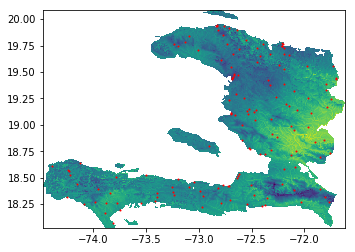

In [11]:
# Plot the recovered EIR map

# Load in the full resolution covariates tif
ds = gdal.Open('data/covariates_AI.tif')
covariate = ds.GetRasterBand(1)
nodata = covariate.GetNoDataValue()
referenceimage = covariate.ReadAsArray()
referenceimage = np.ma.masked_less(referenceimage,-3)

# Sort out the mask
valid_pixels = referenceimage.mask==0
valid_pixels_indices = np.nonzero(np.ndarray.flatten(valid_pixels)) # row-major flattening
n_valid_pixels = np.sum(valid_pixels)

# Get the lats/longs for the pixel values in the rasters
x0, dx, dxdy, y0, dydx, dy = ds.GetGeoTransform()
nrows, ncols = referenceimage.shape
lonarray = np.linspace(x0, x0+dx*ncols, ncols)
latarray = np.linspace(y0, y0+dy*nrows, nrows)
pixel_longs, pixel_lats = np.meshgrid(lonarray, latarray)

# Create image with the inferred EIR
referenceimage.put(np.where(np.ndarray.flatten(referenceimage.mask)==0),linear_predictor)

# Plot it!
plt.scatter(village_longs, village_lats, c='red', s = 1) # check image coordinate transforms by comparing raster plot against observation locations 
imgplot = plt.imshow(referenceimage,extent=[np.min(pixel_longs),np.max(pixel_longs),np.min(pixel_lats),np.max(pixel_lats)])
#plt.scatter(pixel_longs, pixel_lats, c='red', s = 0.001) # check image coordinate transforms by comparing raster plot against observation locations 
plt.xlim(np.min(pixel_longs[valid_pixels]),np.max(pixel_longs[valid_pixels]))
plt.ylim(np.min(pixel_lats[valid_pixels]),np.max(pixel_lats[valid_pixels]))
#plt.colorbar()
plt.show()

In [14]:
sess.run(log_field_at_conditional_mode)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.